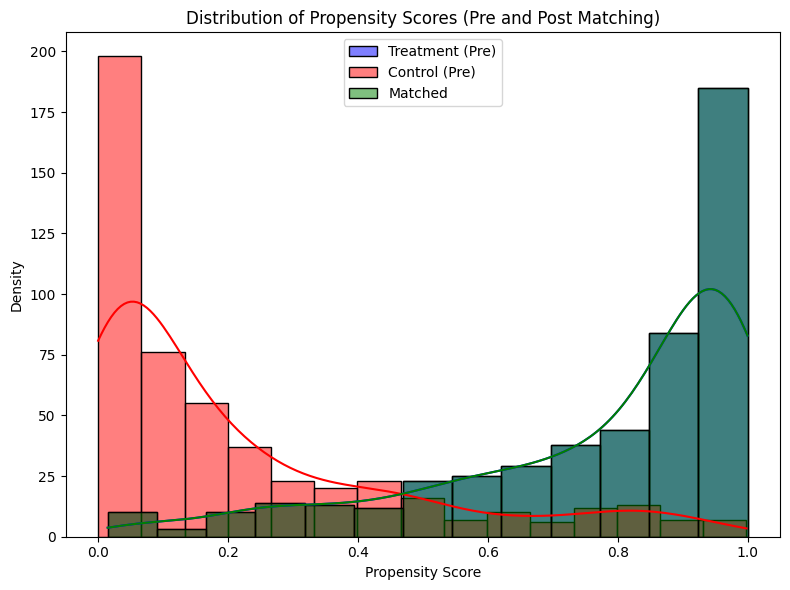

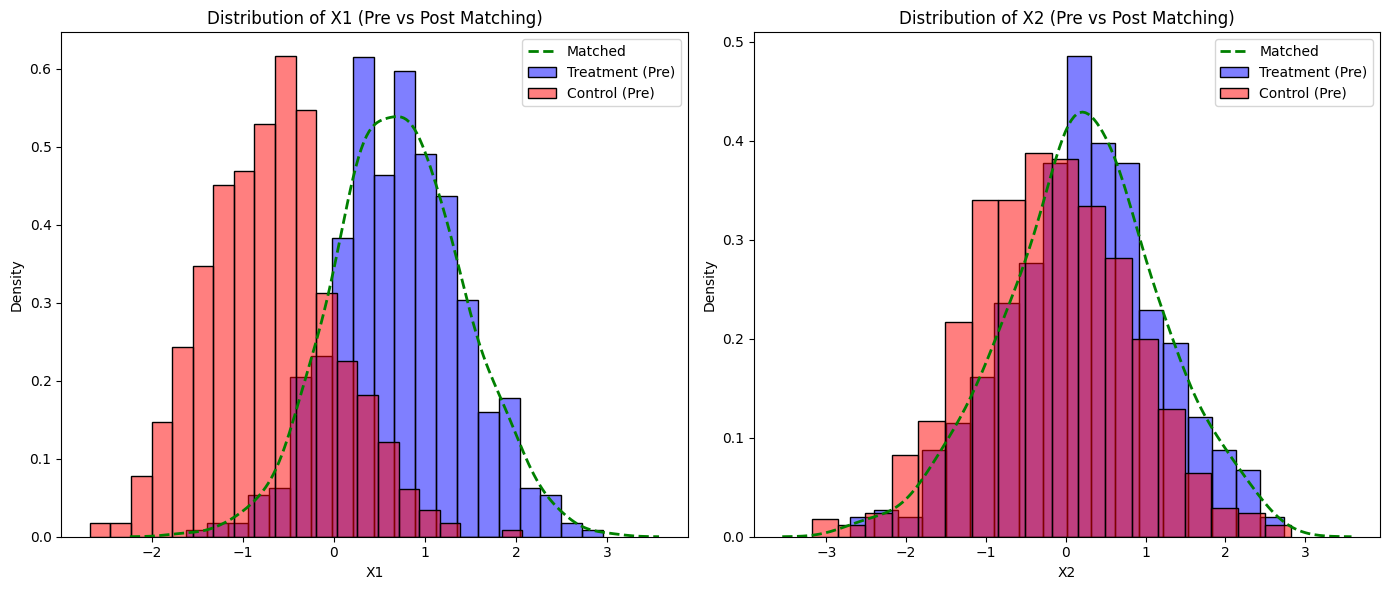

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

# 假设数据：我们有一个处理组 T=1 和对照组 T=0
np.random.seed(42)

# 创建一个数据框
n = 1000  # 样本大小
data = pd.DataFrame({
    'X1': np.random.normal(0, 1, n),  # 协变量X1
    'X2': np.random.normal(5, 2, n),  # 协变量X2
    'T': np.random.choice([0, 1], size=n)  # 处理组和对照组
})

# 假设在匹配之前，处理组和对照组在 X1 和 X2 上有不同的分布
data.loc[data['T'] == 1, 'X1'] += 2  # 处理组在X1上有2的偏移
data.loc[data['T'] == 0, 'X2'] -= 1  # 对照组在X2上有1的偏移

# 标准化协变量（倾向得分模型使用标准化的协变量）
scaler = StandardScaler()
data[['X1', 'X2']] = scaler.fit_transform(data[['X1', 'X2']])

# 步骤 1：估计倾向得分
# 使用逻辑回归估计倾向得分
model = LogisticRegression()
model.fit(data[['X1', 'X2']], data['T'])
data['propensity_score'] = model.predict_proba(data[['X1', 'X2']])[:, 1]

# 步骤 2：根据倾向得分进行最近邻匹配
# 使用最近邻匹配来配对处理组和对照组
nn = NearestNeighbors(n_neighbors=1)
nn.fit(data[data['T'] == 0][['propensity_score']])
distances, indices = nn.kneighbors(data[data['T'] == 1][['propensity_score']])

# 得到匹配对的对照组索引
matched_control_indices = data[data['T'] == 0].iloc[indices.flatten()].index

# 步骤 3：将匹配的对照组添加到处理组中
matched_data = data.loc[data['T'] == 1].copy()
matched_data['matched_control'] = data.loc[matched_control_indices, 'T'].values

# 步骤 4：可视化匹配效果
# 1. 绘制倾向得分的分布（匹配前后的对比）
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.histplot(data[data['T'] == 1]['propensity_score'], kde=True, color='blue', label='Treatment (Pre)', ax=ax)
sns.histplot(data[data['T'] == 0]['propensity_score'], kde=True, color='red', label='Control (Pre)', ax=ax)
sns.histplot(matched_data['propensity_score'], kde=True, color='green', label='Matched', ax=ax)
ax.set_title('Distribution of Propensity Scores (Pre and Post Matching)')
ax.set_xlabel('Propensity Score')
ax.set_ylabel('Density')
ax.legend()

plt.tight_layout()
plt.show()

# 2. 绘制匹配后的协变量分布
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 绘制 X1 的匹配前后分布
sns.histplot(data[data['T'] == 1]['X1'], color='blue', label='Treatment (Pre)', ax=axes[0], stat='density', alpha=0.5)
sns.histplot(data[data['T'] == 0]['X1'], color='red', label='Control (Pre)', ax=axes[0], stat='density', alpha=0.5)
sns.kdeplot(matched_data['X1'], color='green', label='Matched', ax=axes[0], linestyle='--', linewidth=2)
axes[0].set_title('Distribution of X1 (Pre vs Post Matching)')
axes[0].set_xlabel('X1')
axes[0].set_ylabel('Density')
axes[0].legend()


# 绘制 X2 的匹配前后分布
sns.histplot(data[data['T'] == 1]['X2'], color='blue', label='Treatment (Pre)', ax=axes[1], stat='density', alpha=0.5)
sns.histplot(data[data['T'] == 0]['X2'], color='red', label='Control (Pre)', ax=axes[1], stat='density', alpha=0.5)
sns.kdeplot(matched_data['X2'], color='green', label='Matched', ax=axes[1], linestyle='--', linewidth=2)
axes[1].set_title('Distribution of X2 (Pre vs Post Matching)')
axes[1].set_xlabel('X2')
axes[1].set_ylabel('Density')
axes[1].legend()

plt.tight_layout()
plt.show()
